In [1]:
import pandas as pd
import os
from dotenv import load_dotenv
import requests
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
dfinfo = pd.read_csv("dfinfo_apex.csv")

In [3]:
# Variables predictoras y objetivo
X_base = dfinfo.drop(columns='my_team_win')
y_base = dfinfo['my_team_win']

# División en entrenamiento y prueba
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train_base, y_train_base)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [4]:
model = LogisticRegression(
    penalty='l1',    # l2 es default
    C=0.1,           # higher C = menos regularización
    solver='saga',   # lbfgs para l2, saga soporta l1
    random_state=7,
    max_iter=10000,
    fit_intercept=True
)
model.fit(X_train_base, y_train_base)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,7
,solver,'saga'
,max_iter,10000
,multi_class,'deprecated'


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),   # paso 1: estandariza
    ("clf", LogisticRegression(
        penalty='l2',
        C=8.0,
        solver='saga',
        random_state=42,
        max_iter=10000,
        fit_intercept=True
    ))
])

pipe.fit(X_train_base, y_train_base)
y_pred = pipe.predict(X_test_base)

In [6]:
y_proba_base = model.predict_proba(X_test_base)[:, 1]  # prob. de clase 1
new_threshold = 0.5
y_pred_adjusted = (y_proba_base >= new_threshold).astype(int)

print("Accuracy:", accuracy_score(y_test_base, y_pred_adjusted))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_base, y_pred_adjusted))
print("\nClassification Report:\n", classification_report(y_test_base, y_pred_adjusted))


Accuracy: 0.6655629139072847

Confusion Matrix:
 [[ 98  48]
 [ 53 103]]

Classification Report:
               precision    recall  f1-score   support

       False       0.65      0.67      0.66       146
        True       0.68      0.66      0.67       156

    accuracy                           0.67       302
   macro avg       0.67      0.67      0.67       302
weighted avg       0.67      0.67      0.67       302



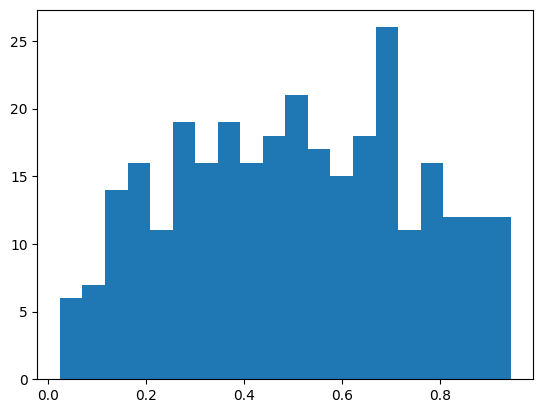

In [7]:
import matplotlib.pyplot as plt
plt.hist(y_proba_base, bins=20); plt.show()

In [ ]:
# Probabilidades de victoria para el conjunto de prueba
probs = model.predict_proba(X_test_base)

# Imprimir la primera predicción de ejemplo:
for i in range(7):
    print(f"Ejemplo {i+1}: Probabilidad de ganar = {probs[i][1]*100:.2f}%")

Ejemplo 1: Probabilidad de ganar = 54.92%
Ejemplo 2: Probabilidad de ganar = 38.36%
Ejemplo 3: Probabilidad de ganar = 56.59%
Ejemplo 4: Probabilidad de ganar = 69.49%
Ejemplo 5: Probabilidad de ganar = 37.98%
Ejemplo 6: Probabilidad de ganar = 42.26%
Ejemplo 7: Probabilidad de ganar = 52.30%


In [7]:

coef_df = pd.DataFrame({
    'Feature': X_base.columns,
    'Coefficient': model.coef_[0]
})

print(coef_df.sort_values(by='Coefficient', ascending=False))


     Feature  Coefficient
0  gold_diff     0.000594
1  kill_diff    -0.002489


Una vez conformes con los resultados del ML se pueden tomar nuevos datos y predecir en base a lo que se ha entrenado el algoritmo.

Lo más importante de los siguientes bloques es la información contenida en "predicted_matches", aquí se almacenan las partidas que serán sometidas a predicción. Puede ser llenado a mano o utilizar la función "get_matchids" para obtener una serie continua de partidas del jugador. 

Se cual sea la metodología, con estas partidas se genera un nuevo dfinfo que es el input para predecir.

In [8]:
gameName = 'Natanaël%20Cano'  #El %20 indica un espacio
tagLine = 'NATA'
api_key = 'RGAPI-c49e8bae-7d35-4552-8c54-e161f8ca848d'
predicts_csv = 'predicts_csv.csv'
matchtype = 'ranked'
queueid = '420' #Default para SoloQ
start = '0'
count = '5'

In [ ]:
from functions import get_df_data, get_puuid, get_matchids
puuid = get_puuid(gameName=gameName, tagLine=tagLine, api_key=api_key)

predicted_matches = get_matchids(puuid=puuid, queueid=queueid, matchtype=matchtype, start=start, count=count, api_key=api_key)
print(predicted_matches)

#predicted_matches=['','','']

['LA1_1642972444', 'LA1_1642962195', 'LA1_1642710668', 'LA1_1642704329', 'LA1_1642695796']


In [10]:
df = pd.DataFrame(get_df_data(history = predicted_matches, puuid = puuid, api_key = api_key, csv_path = predicts_csv))
df.to_csv(predicts_csv, index=False)

[LA1_1642972444] Ya estaba registrado, se omite.
[LA1_1642962195] Ya estaba registrado, se omite.
[LA1_1642710668] Ya estaba registrado, se omite.
[LA1_1642704329] Ya estaba registrado, se omite.
[LA1_1642695796] Ya estaba registrado, se omite.


In [13]:
df = pd.read_csv('predicts_csv.csv')

features = ['gold_diff', 'gold_leading_team', 'kill_diff', 'kill_leading_team', 'my_team']

match_ids = df['match_id']
X_pred = df[features]

In [14]:
probs = model.predict_proba(X_pred)[:, 1]  # prob. de victoria (=1)

results = pd.DataFrame({
    "match_id": match_ids,
    "prob_victoria": probs 
})

print(results)

         match_id  prob_victoria
0  LA1_1642972444       0.325888
1  LA1_1642962195       0.388039
2  LA1_1642710668       0.386514
3  LA1_1642704329       0.537351
4  LA1_1642695796       0.541418


c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\eeeli\OneDrive\Documentos\workspace\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:726: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_it

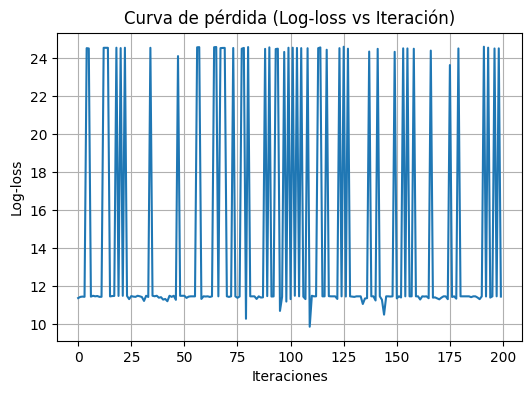

In [8]:
from functions import plot_loss_curve, plot_entropy_vs_diff, plot_calibration_curve, plot_roc_curve
plot_loss_curve(X_train_base, y_train_base, max_iter=200)

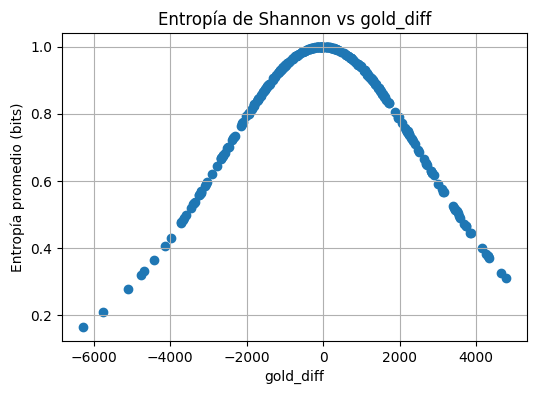

In [9]:

plot_entropy_vs_diff(model, X_test_base, dfinfo.loc[X_test_base.index], diff_col="gold_diff")

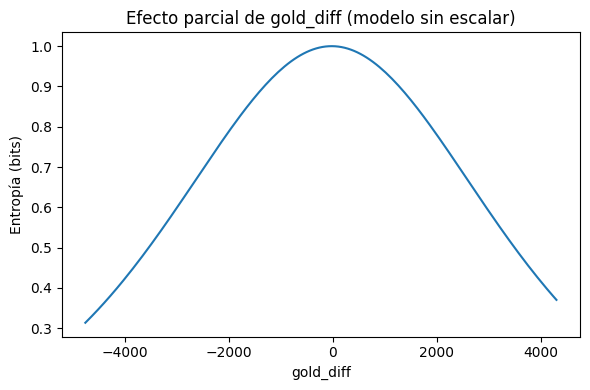

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import entropy_bits

# === Configura ===
features = ['gold_diff','kill_diff']  # las mismas del entrenamiento

# 1) Punto de referencia (medianas, SIN escalar)
ref = X_test_base[features].median().to_frame().T

# 2) Barrido en gold_diff
gmin, gmax = X_test_base['gold_diff'].quantile([0.01, 0.99])
grid = np.linspace(gmin, gmax, 150)
grid_df = pd.concat([ref]*len(grid), ignore_index=True)
grid_df['gold_diff'] = grid

# 3) **Sin** escalar (modelo entrenado sin scaler)
p = model.predict_proba(grid_df[features])[:, 1]
H = entropy_bits(p)

# 4) Plot
plt.figure(figsize=(6,4))
plt.plot(grid, H)
plt.xlabel('gold_diff')
plt.ylabel('Entropía (bits)')
plt.title('Efecto parcial de gold_diff (modelo sin escalar)')
plt.tight_layout()
plt.show()


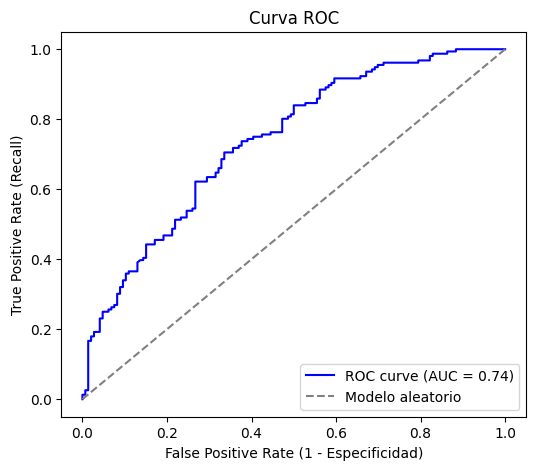

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener probabilidades de la clase positiva
y_proba = model.predict_proba(X_test_base)[:, 1]

# Calcular puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_base, y_proba)

# Calcular AUC
roc_auc = roc_auc_score(y_test_base, y_proba)

# Graficar
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Modelo aleatorio')
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()



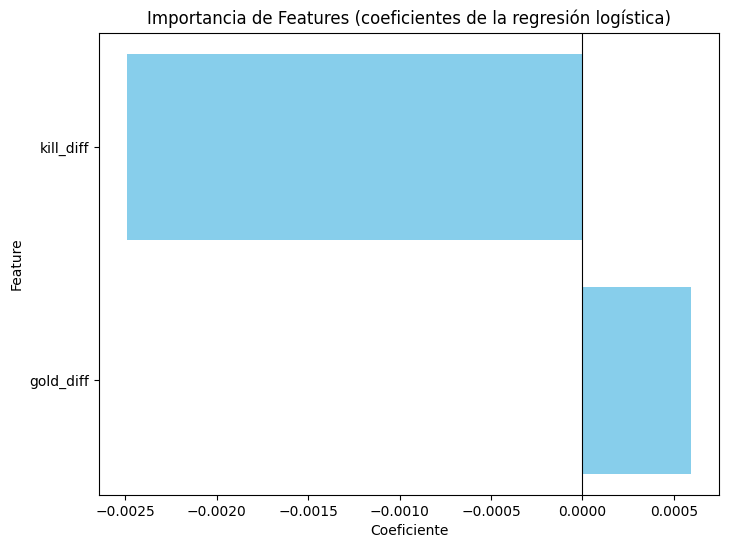

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Obtener coeficientes
coefs = model.coef_[0]  # modelo binario → una sola fila
features = X_train_base.columns

# Crear dataframe ordenado
importance = pd.DataFrame({
    "Feature": features,
    "Coef": coefs,
    "AbsCoef": np.abs(coefs)
}).sort_values(by="AbsCoef", ascending=True)

# Plot
plt.figure(figsize=(8,6))
plt.barh(importance["Feature"], importance["Coef"], color="skyblue")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Importancia de Features (coeficientes de la regresión logística)")
plt.xlabel("Coeficiente")
plt.ylabel("Feature")
plt.show()


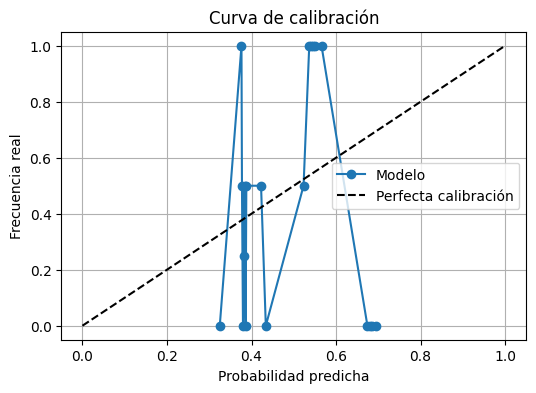

Brier Score: 0.2647120413644139


In [ ]:
plot_calibration_curve(model, X_test_base, y_test_base, n_bins=15)
